In [88]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\scirep-cuisines-detail"
FILES = ["allr_recipes.txt","epic_recipes.txt","menu_recipes.txt"]

In [164]:
recipes = []
for file in FILES:
    with open(os.path.join(FOLDER_PATH,file)) as f:
        for i,recipe in enumerate(f):
            data = recipe.strip('\n').split('\t')
            recipes.append({"cuisine":data[0],"id":i,"ingredients":data[1:]})
        
df_train = pd.DataFrame(recipes)
df_train

,cuisine,id,ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]"
1,Canada,1,"[pork, carrot, pea, onion, potato]"
2,Canada,2,[maple_syrup]
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget..."
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po..."
...,...,...,...
57686,italian,2453,"[kiwi, olive_oil, clam, white_wine, orange, sa..."
57687,italian,2454,"[tomato, butter, beef, onion, red_wine, black_..."
57688,italian,2455,"[vegetable, wheat, egg, cheese, olive_oil]"
57689,italian,2456,"[tomato, clam, black_pepper, parsley, celery, ..."


# Data analysis

American        40150
Mexico           1754
Italian          1715
Italy            1461
Asian            1176
                ...  
Indonesia          12
East-African       11
Belgium            11
Israel              9
Bangladesh          4
Name: cuisine, Length: 69, dtype: int64

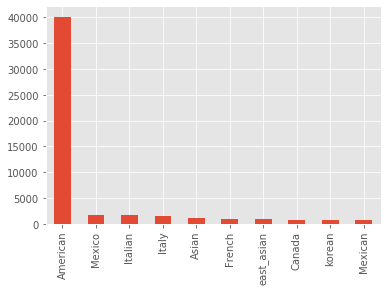

In [165]:
%matplotlib inline

plt.style.use('ggplot')
df_train['cuisine'].value_counts().head(10).plot(kind='bar')

df_train['cuisine'].value_counts()

In [166]:
# remove most americans for now, to have better distribution of cuisines
df_train=df_train.replace("Mexico","Mexican")
print(len(df_train))

american_df = df_train[df_train["cuisine"]=="American"].sample(frac=0.9)
print(len(american_df))
df_train=df_train[~df_train.isin(american_df).all(1)]
print(len(df_train))

57691
36135
21556


Results are worse when we remove American recipes!
Check what exactly are those results
See if we should remove american, if yes, how to improve score ???

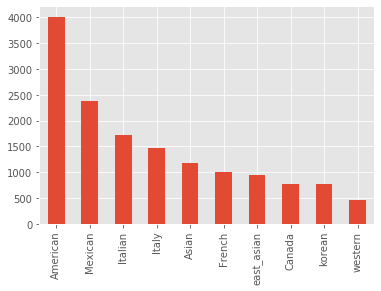

In [167]:
df_train['cuisine'].value_counts().head(10).plot(kind='bar')

In [168]:
fraction_of_rows["id"]

23016    23016
35113    35113
30910    30910
7976      7976
7936      7936
         ...  
12011    12011
6906      6906
19425    19425
44934     3109
46863     5038
Name: id, Length: 32120, dtype: int64

In [169]:
counters = {}
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [170]:
counters['italian'].most_common(10)

[('black_pepper', 54),
 ('olive_oil', 40),
 ('onion', 37),
 ('garlic', 32),
 ('macaroni', 30),
 ('tomato', 29),
 ('wheat', 28),
 ('butter', 27),
 ('white_wine', 21),
 ('basil', 20)]

In [171]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
Canada,wheat,butter,egg,onion,garlic,milk,black_pepper,cane_molasses,vegetable_oil,pepper
Turkey,garlic,onion,tomato,butter,wheat,yogurt,olive_oil,bell_pepper,pepper,egg
Caribbean,onion,garlic,vegetable_oil,black_pepper,tomato,olive_oil,pepper,cayenne,bell_pepper,chicken
Bangladesh,onion,cayenne,vegetable_oil,turmeric,garlic,cilantro,coriander,beef,potato,cardamom
India,cumin,onion,turmeric,garlic,cayenne,coriander,ginger,vegetable_oil,pepper,tomato
...,...,...,...,...,...,...,...,...,...,...
east_asian,garlic,soy_sauce,scallion,cayenne,sesame_oil,black_pepper,rice,ginger,vegetable_oil,soybean
asian,rice,black_pepper,coriander,cayenne,onion,garlic,vegetable,fish,cucumber,shrimp
western,egg,wheat,butter,black_pepper,onion,milk,vegetable_oil,tomato,garlic,vinegar
korean,garlic,scallion,cayenne,soy_sauce,sesame_oil,black_pepper,rice,soybean,roasted_sesame_seed,vegetable


In [172]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)
df_train.head()

,cuisine,id,ingredients,all_ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]",egg;yeast;wheat;milk;lard
1,Canada,1,"[pork, carrot, pea, onion, potato]",pork;carrot;pea;onion;potato
2,Canada,2,[maple_syrup],maple_syrup
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget...",wheat;yeast;almond;honey;oat;date;vegetable_oi...
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po...",butter;lovage;clam;wheat;onion;thyme;potato;ye...


In [173]:
df_train['all_ingredients'].str.contains('garlic').value_counts()

False    12797
True      8759
Name: all_ingredients, dtype: int64

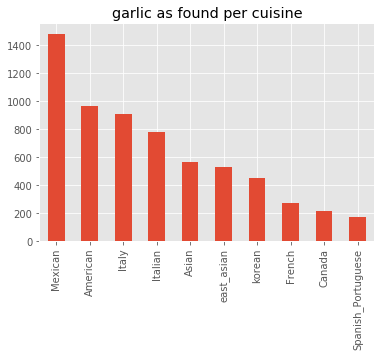

In [174]:
indices = df_train['all_ingredients'].str.contains('garlic')
df_train[indices]['cuisine'].value_counts().head(10).plot(kind='bar',
                                                 title='garlic as found per cuisine')

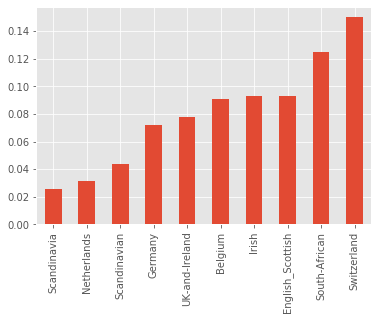

In [175]:
relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
relative_freq.sort_values(inplace=True)
relative_freq.head(10).plot(kind='bar')

In [176]:
unique = np.unique(top10.values.ravel())
unique.shape

(79,)

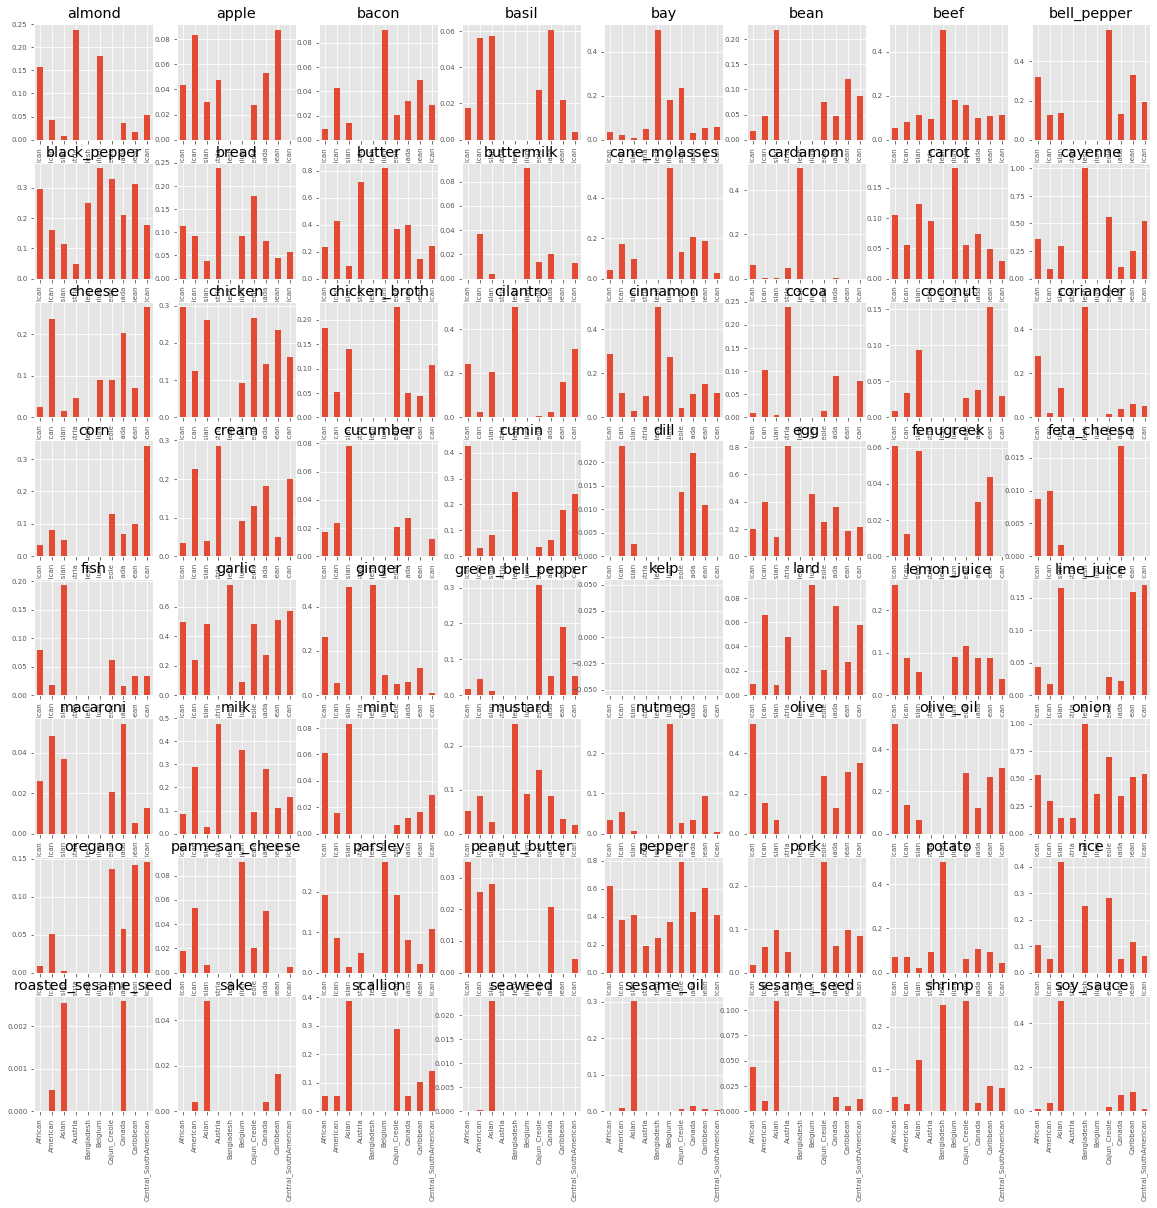

In [177]:
# spot ingredients which have a high degree of uniqueness

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = df_train['all_ingredients'].str.contains(ingredient)
    relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
    relative_freq.head(10).plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

In [178]:
# np.array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
#        'black pepper', 'butter', 'buttermilk', 'cachaca',
#        'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
#        'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
#        'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
#        'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
#        'fresh lime juice', 'garam masala', 'garlic', 'garlic cloves',
#        'ginger', 'grated parmesan cheese', 'green bell pepper',
#        'green onions', 'ground allspice', 'ground black pepper',
#        'ground cinnamon', 'ground cumin', 'ground ginger',
#        'ground turmeric', 'jalapeno chilies', 'large eggs', 'lime', 'milk',
#        'mirin', 'oil', 'olive oil', 'onions', 'paprika', 'pepper',
#        'potatoes', 'red bell pepper', 'rice vinegar', 'sake', 'salt',
#        'scallions', 'sesame oil', 'sesame seeds', 'shallots', 'sour cream',
#        'soy sauce', 'sugar', 'tomatoes', 'unsalted butter',
#        'vegetable oil', 'water']).shape

In [179]:
cv = CountVectorizer()

X = cv.fit_transform(df_train['all_ingredients'].values)
X.shape
# 57691 recipes, 383 ingredients

(21556, 370)

In [180]:
print(list(cv.vocabulary_.keys())[:100])

['egg', 'yeast', 'wheat', 'milk', 'lard', 'pork', 'carrot', 'pea', 'onion', 'potato', 'maple_syrup', 'almond', 'honey', 'oat', 'date', 'vegetable_oil', 'whole_grain_wheat_flour', 'butter', 'lovage', 'clam', 'thyme', 'black_pepper', 'parsley', 'ginger', 'bay', 'celery', 'cinnamon', 'mustard', 'cane_molasses', 'raisin', 'cream', 'asparagus', 'olive_oil', 'pepper', 'garlic', 'tomato', 'cilantro', 'tea', 'jasmine', 'vegetable', 'brown_rice', 'lemon_juice', 'soy_sauce', 'white_wine', 'chicken', 'vanilla', 'rice', 'mushroom', 'chicken_broth', 'basil', 'porcini', 'mozzarella_cheese', 'tuna', 'lemon', 'beef', 'fish', 'cocoa', 'green_bell_pepper', 'oregano', 'rosemary', 'coffee', 'banana', 'squash', 'egg_noodle', 'bell_pepper', 'cheddar_cheese', 'broccoli', 'cayenne', 'scallion', 'lettuce', 'cucumber', 'cream_cheese', 'melon', 'cranberry', 'peanut', 'nut', 'chickpea', 'yogurt', 'bread', 'tabasco_pepper', 'cod', 'bacon', 'pimento', 'black_tea', 'grapefruit', 'orange_juice', 'pineapple', 'vinegar

In [181]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
y
enc.classes_.shape

(68,)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Logistic Regression

In [183]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [184]:
logistic.score(X_test, y_test)

0.4427179962894249

Text(0.5, -0.6216666666666981, 'Predicted label')

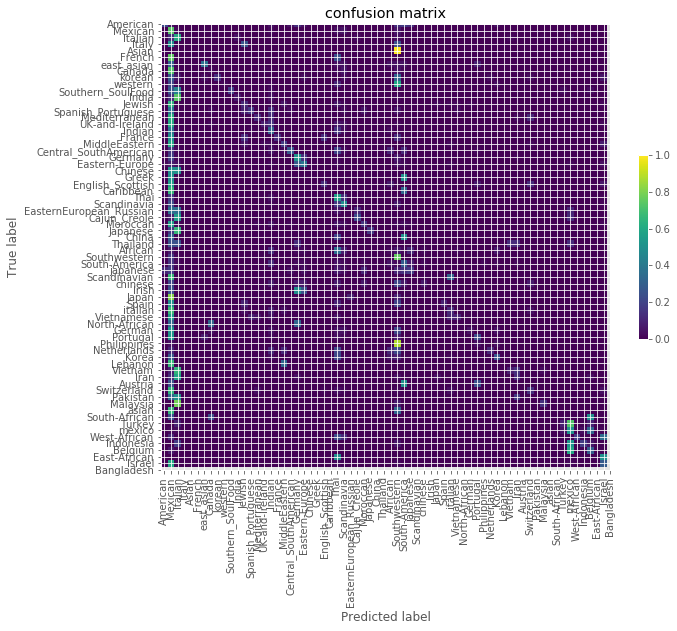

In [185]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = df_train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [186]:
y_pred = logistic.predict(X_test)

print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=cuisines))

                         precision    recall  f1-score   support

               American       0.56      0.22      0.31        23
                Mexican       0.37      0.74      0.49       753
                Italian       0.44      0.62      0.51       224
                  Italy       0.00      0.00      0.00         4
                  Asian       0.00      0.00      0.00         1
                 French       0.00      0.00      0.00         4
             east_asian       0.36      0.36      0.36        22
                 Canada       0.21      0.02      0.04       148
                 korean       0.83      0.14      0.24        36
                western       0.33      0.02      0.03        57
      Southern_SoulFood       0.86      0.19      0.32        31
                  India       0.23      0.07      0.10        46
                 Jewish       0.00      0.00      0.00         0
     Spanish_Portuguese       0.35      0.11      0.17        53
          Mediterranean 

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 69, does not match size of target_names, 68
  .format(len(labels), len(target_names))
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [187]:
y_pred

array([ 1,  2,  1, ..., 36, 56, 62])

# Random Forest

much slower and a bit worse

In [188]:
# Random Forest PCA
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=460, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=460,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [189]:
rf.score(X_test, y_test)

0.3856679035250464

In [190]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=cuisines))

                         precision    recall  f1-score   support

               American       0.07      0.04      0.05        23
                Mexican       0.40      0.67      0.50       753
                Italian       0.34      0.47      0.39       224
                  Italy       0.00      0.00      0.00         4
                  Asian       0.00      0.00      0.00         1
                 French       0.00      0.00      0.00         4
             east_asian       0.29      0.23      0.26        22
                 Canada       0.15      0.05      0.08       148
                 korean       0.25      0.06      0.09        36
                western       0.04      0.02      0.02        57
      Southern_SoulFood       0.17      0.03      0.05        31
                  India       0.00      0.00      0.00        46
                 Jewish       0.00      0.00      0.00         0
     Spanish_Portuguese       0.39      0.23      0.29        53
          Mediterranean 

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 69, does not match size of target_names, 68
  .format(len(labels), len(target_names))
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
